In [4]:
from header import *
from scipy import optimize
plt.rcParams.update({'font.size': 16})
plots_dir = Path('imgs/')
timelimit = 150

In [5]:
def plot_scaling(df, x, y, prefix, hline=False, algo1=None, algo2=None, show_mean=False, trend_line=False, xlog=False, ylog=False, title=None):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F3F3F3')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['alg', x], group_keys=False, observed=True)[y].mean()  # observed=True drops categorical algos that don't appear
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='alg', values='mean_{}'.format(y))
   
    if trend_line == "exp":        
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(s.index, np.log(s), 1)
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # ln(y[i]) ~= a*x[i] + b
        #  => y[i] ~= exp(a*x[i] + b)
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     a*x[1] + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(np.exp(a*i+b))
            #display(regression_line)
            ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = '$\sim {{{:0.2f}}}^x$'.format(np.exp(a*(s.index[1]-s.index[0])))
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line == "poly":
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(np.log(s.index), np.log(s), 1)
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # log(y[i]) ~= a*log(x[i]) + b
        #  => y[i] ~= e^(a*log(x[i]) + b) = x[i]^a * e^b
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     x[i]*[ * + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append((i**a) * np.exp(b))
            #display(regression_line)
            
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = ''
            if len(d[algo].dropna()) > 1:
                ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
                label = '$\sim x^{{{:0.2f}}}$'.format(a)
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line == "lin_poly":
        z = {}
        f = lambda x, a, b, c: a*x + b*x**c
        fe = lambda x, a, b, c: np.log(a*x + b*x**c)
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = optimize.curve_fit(fe, 
                                         s.index, 
                                         np.log(s), 
                                         p0=[1e-10, 1e-10, 2.5],
                                         bounds=([1e-20,1e-20,1], [1e-5, 1e-5, 3])
                                        )[0]
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        
        # Best fit lines
        j = 0
        for algo in d.columns:
            j += 1
            regression_line = []
            params = z[algo]
            print(algo, params)
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(f(i, *params))
            #display(regression_line)
            
            weight = algo == 'PA'
            label = ''
            if len(d[algo].dropna()) > 1:
                ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
                label = '$\sim {:0.2f} x + {:0.2f} * x^{{{:0.2f}}}$'.format(*params)
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line is not False:
        print(trend_line)
        assert(False)
    
    # ticks
    if x == 'error_rate':
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    
    if x == 'cost':
        ax.set_xticks(np.arange(0, max(df[x])+1, 1))
    
    #arr = [ 0 ] + [ 10**n for n in range(0,int(math.log10(max(df[y])))+1) ]
    #ax.set_yticks(arr)

    # Times
    #for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
    #    label = '{0:.3g}x'.format(row[algo1] / row[algo2])
    #    tmp_x = index if index != 'all' else len(d)-1
    #    tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
    #    ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot(ax=ax, alpha=0.6, zorder=3, rot=0, color=colors, marker='o', ls='', legend=False)
    #d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    #if hline:
    #    ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 15}, framealpha=0.5)
    #else:
    #    ax.legend(loc="upper left", prop={'size': 15}, framealpha=0.5)

    if hline:
        if y == 'explored_states' or y == 'crumbs':
            miny = df.len.median()
            maxy = df.refsize.median()*df.len.median()
        elif y == 'explored_per_bp':
            miny = 1
            maxy = df.refsize.median()
        else:
            assert(False)
        
        ax.axhline(maxy, color='k', linestyle='--', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(0.0, maxy, 'max    ', ha='right', va='center', size=16)
        
        ax.axhline(y=miny, color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(0.0, miny, 'min    ', ha='right', va='center', size=16)

    if ylog:
        ax.set_yscale('log')
        
    if xlog:
        ax.set_xscale('log')
      
    if title:
        ax.set_title(title)
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labelsi
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

edlib [2.25756486e-07 5.73584940e-11 1.80579358e+00]
pa [9.13829863e-08 4.16522711e-11 1.56869395e+00]
wfa [1.37893495e-08 3.33461348e-11 1.68719309e+00]
edlib [2.11439864e-07 6.49571558e-11 1.88240857e+00]
pa [1.59009399e-07 5.57881166e-11 1.62891304e+00]
wfa [2.51033392e-08 6.12775373e-11 1.80452834e+00]
edlib [2.05955714e-07 7.21013671e-11 1.96401254e+00]
pa [1.00012058e-20 3.90860773e-07 1.11746973e+00]
wfa [7.69719830e-08 1.26024880e-10 1.81094251e+00]


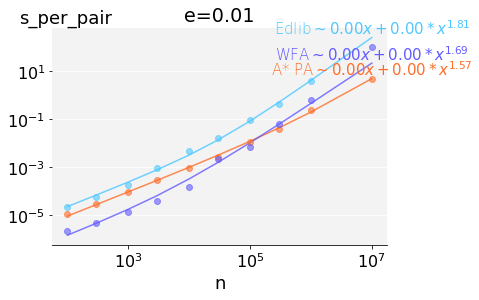

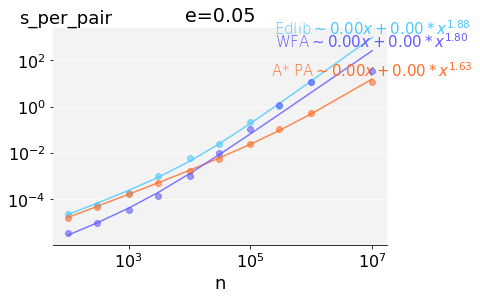

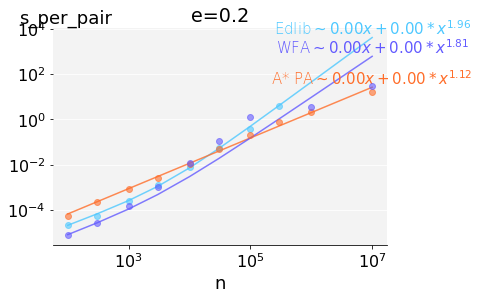

In [6]:
# TOOL COMPARISON -- uses best params for PA
df = read_benchmarks('../data/table/tools_N10000000.tsv').dropna()

df = df[ df.s < timelimit ]
df = df[df.alg != 'dijkstra']

for e in [0.01, 0.05, 0.2]:
    df_n = df[df.e == e]
    #display(df_n)
    plot_scaling(df_n, y='s_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True, trend_line='lin_poly', title='e={}'.format(e))
    #plot_scaling(df_e, y='s_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)

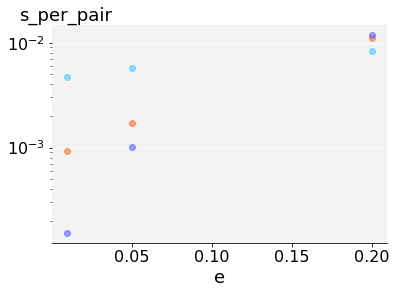

In [7]:
# SCALING WITH e
df = read_benchmarks('../data/table/tools_N10000000.tsv').dropna()
df = df[df.n == 10000]
#display(df)
plot_scaling(df, y='s_per_pair', x='e', prefix=experiment_name, xlog=False, ylog=True, trend_line=False)

In [8]:
df = read_benchmarks('../data/table/tools_N10000000.tsv').dropna()
df = df[df.e == 0.2] 
df = df[df.alg == 'pa']
display(df)

,alg,cnt,n,e,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,s_per_pair
18,pa,100000,100,0.2,5.5732,0:00:05,33.22,45.61,27.12,27.51,0.00,0.0,82.37,5.07,0.000056
19,pa,100000,100,0.2,5.6271,0:00:05,33.20,45.61,27.12,27.50,0.00,0.0,82.49,5.11,0.000056
20,pa,100000,100,0.2,5.5571,0:00:05,33.30,45.61,27.12,27.51,0.00,0.0,82.06,5.04,0.000056
33,pa,33333,300,0.2,7.6885,0:00:07,28.77,41.35,22.84,23.67,0.00,0.0,86.45,7.13,0.000231
54,pa,10000,1000,0.2,8.2545,0:00:08,27.16,38.46,21.15,21.54,0.00,0.0,87.60,7.72,0.000825
55,pa,10000,1000,0.2,8.2979,0:00:08,26.99,38.46,21.14,21.51,0.00,0.0,87.49,7.74,0.000830
56,pa,10000,1000,0.2,8.2834,0:00:08,27.07,38.46,21.14,21.53,0.00,0.0,87.16,7.70,0.000828
69,pa,3333,3000,0.2,8.9379,0:00:08,27.54,38.65,21.49,22.18,0.00,0.0,92.76,8.78,0.002682
90,pa,1000,10000,0.2,11.0590,0:00:11,30.91,42.26,25.02,25.42,0.00,0.0,93.85,10.87,0.011059
91,pa,1000,10000,0.2,11.0926,0:00:11,31.05,42.26,25.02,25.43,0.00,0.0,94.03,10.92,0.011093


,alg,cnt,n,e,m,k,pf,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,nr,|a|,|b|,r,H,k.1,md,pr,bf,dist,seeds,matches,expanded,explored,dbl,ret,band,precom,align,prune,dist.1,Unnamed: 38,m_pat,m_exp,s_per_pair
0,pa,1000000,100,0.05,0,15,1.0,8.2317,0:00:08,267.24,279.70,261.85,262.49,0.0,0.0,92.33,7.99,1000000,100,99,0.0,GapSeed,15,0,1,NaN,Gap,6,3,108,120,0,0,1.21,0.00,0.01,0.00,4,3,NaN,NaN,0.000008
1,pa,333333,300,0.05,0,15,1.0,8.2941,0:00:08,225.83,244.93,220.57,221.21,0.0,0.0,91.52,7.98,333333,300,299,0.0,GapSeed,15,0,1,NaN,Gap,20,10,339,386,1,10,1.29,0.00,0.02,0.00,13,10,NaN,NaN,0.000025
2,pa,100000,1000,0.05,0,15,1.0,9.8498,0:00:09,205.80,217.23,200.23,200.88,0.0,0.0,92.39,9.49,100000,1000,999,0.0,GapSeed,15,0,1,NaN,Gap,66,34,1194,1382,4,165,1.38,0.02,0.08,0.01,44,34,NaN,NaN,0.000098
3,pa,33333,3000,0.05,0,15,1.0,10.5453,0:00:10,201.46,213.17,196.13,196.78,0.0,0.0,91.05,9.99,33333,3000,2999,0.0,GapSeed,15,0,1,NaN,Gap,200,104,3682,4278,15,960,1.43,0.05,0.26,0.02,132,101,NaN,NaN,0.000316
4,pa,10000,10000,0.05,0,15,1.0,9.9315,0:00:09,201.00,211.55,195.61,196.28,0.0,0.0,91.52,9.48,10000,10000,9999,0.0,GapSeed,15,0,1,NaN,Gap,666,349,12446,14489,54,5073,1.45,0.12,0.83,0.07,441,336,NaN,NaN,0.000993
5,pa,3333,30000,0.05,0,15,1.0,10.6670,0:00:10,203.96,214.25,198.54,199.20,0.0,0.0,94.78,10.50,3333,30000,29999,0.0,GapSeed,15,0,1,NaN,Gap,2000,1050,37519,43704,165,20284,1.46,0.38,2.72,0.20,1322,1008,NaN,NaN,0.003200
6,pa,1000,100000,0.05,0,15,1.0,15.6895,0:00:15,215.10,227.45,209.82,210.48,0.0,0.0,93.52,15.07,1000,100000,100001,0.0,GapSeed,15,0,1,NaN,Gap,6666,3502,125201,145869,550,85835,1.46,2.27,12.84,0.92,4407,3359,NaN,NaN,0.015690
7,pa,333,300000,0.05,0,15,1.0,20.4522,0:00:20,258.54,273.28,253.46,254.10,0.0,0.0,71.63,15.04,333,300000,299998,0.0,GapSeed,15,0,1,NaN,Gap,20000,10511,375765,437791,1663,306532,1.46,10.37,48.14,2.96,13222,10079,NaN,NaN,0.061418
8,pa,100,1000000,0.05,0,15,1.0,26.0026,0:00:26,390.72,415.86,386.58,387.20,0.0,0.0,56.46,15.06,100,1000000,999994,0.0,GapSeed,15,0,1,NaN,Gap,66666,35095,1252767,1459663,5537,1202044,1.46,47.79,202.83,11.35,44066,33581,NaN,NaN,0.260026
9,pa,33,3000000,0.05,0,15,1.0,30.6038,0:00:30,909.93,939.01,908.39,909.06,0.0,0.0,47.90,15.06,33,3000000,3000020,0.0,GapSeed,15,0,1,NaN,Gap,200000,105627,3760023,4381202,16490,4097702,1.46,134.12,764.09,39.58,132229,100781,NaN,NaN,0.927388


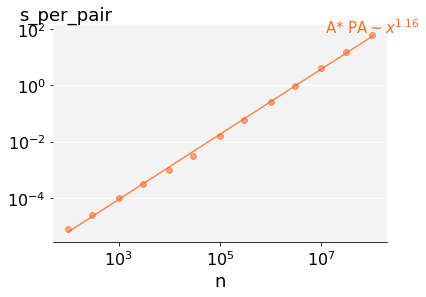

In [11]:
experiment_name = 'linear'

df = read_benchmarks('../data/table/linear_N100000000_e0.05_m0_k15_pf1.0.tsv')

display(df)
plot_scaling(df, y='s_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True, trend_line="poly")

In [77]:
# Best params per input
df = read_benchmarks('../data/table/params_N10000000.tsv')
df = df.dropna()

# Data
d = df.loc[df.groupby(['alg', 'cnt', 'n', 'e']).s.idxmin()]
display(d)

,alg,cnt,n,e,k,m,pf,band,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,s_per_pair
2427,pa,1,10000000,0.01,20,0,1.00,1.028,4.8882,0:00:04,1367.24,1404.85,1367.15,1367.28,0.73,0.0,75.86,4.21,4.888200
2467,pa,1,10000000,0.05,15,0,1.00,1.459,12.1509,0:00:12,3120.93,3253.49,3095.94,3096.71,0.00,0.0,71.77,9.21,12.150900
2135,pa,10,1000000,0.01,20,0,1.00,1.028,2.5245,0:00:02,84.97,144.36,79.11,79.76,0.00,0.0,61.27,2.04,0.252450
2202,pa,10,1000000,0.05,12,0,1.00,1.278,5.0708,0:00:05,205.81,230.00,199.49,199.90,0.00,0.0,81.85,4.64,0.507080
2389,pa,10,1000000,0.20,11,1,1.00,7.615,80.4458,0:01:20,768.80,817.16,768.07,768.74,0.00,0.0,93.38,75.61,8.044580
2003,pa,33,300000,0.01,20,0,1.00,1.028,1.2860,0:00:01,57.36,70.31,51.45,52.28,0.00,0.0,39.51,1.00,0.038970
2039,pa,33,300000,0.05,12,0,1.00,1.277,3.4959,0:00:03,61.42,72.41,55.36,56.07,0.00,0.0,74.39,3.09,0.105936
2107,pa,33,300000,0.20,11,1,1.00,7.610,42.6268,0:00:42,193.28,204.93,187.10,187.81,0.00,0.0,35.26,15.52,1.291721
1655,pa,100,100000,0.01,20,0,1.00,1.028,1.1196,0:00:01,35.76,47.02,29.67,30.35,0.00,0.0,45.56,1.00,0.011196
1761,pa,100,100000,0.05,12,0,1.00,1.280,2.4254,0:00:02,43.54,55.87,37.48,37.90,0.00,0.0,64.28,2.05,0.024254
